## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## Creating Squared Returns

In [9]:
df['squared_returns'] = df.returns.mul(df.returns)

## Returns vs Squared Returns

Text(0.5, 1.0, 'Volatility')

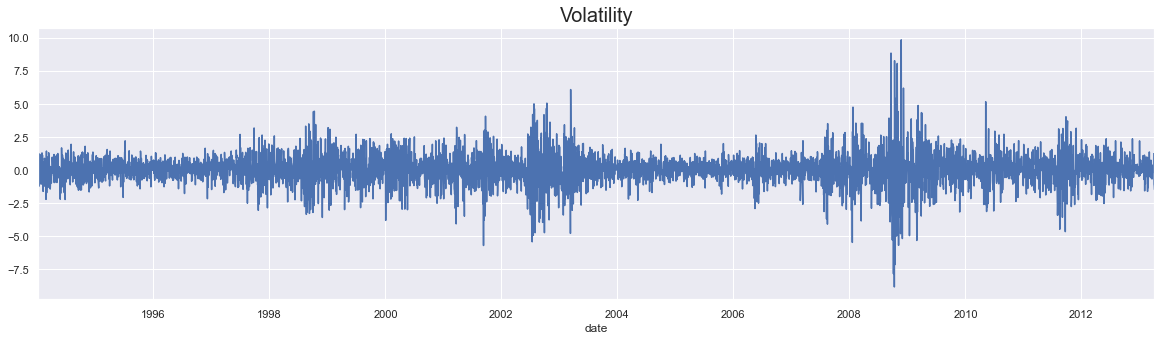

In [10]:
df.returns.plot(figsize=(20,5))
plt.title('Volatility', size=20)

Text(0.5, 1.0, 'Volatility')

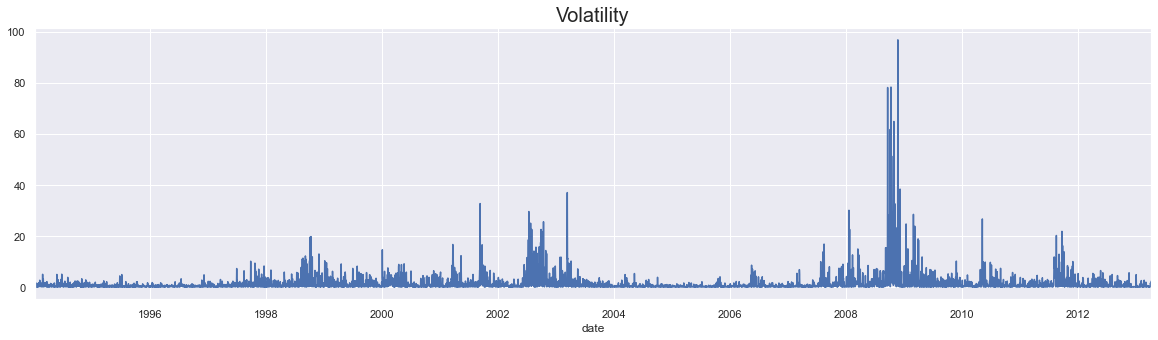

In [11]:
df.squared_returns.plot(figsize=(20,5))
plt.title('Volatility', size=20)

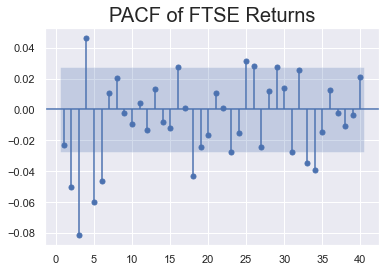

In [14]:
# if time series resembles white noise, and the squared term suggests using AR(N), we can use ARCH(N) to model variance
# such graph shows that it's not really white noise alike
sgt.plot_pacf(df.returns[1:], zero=False, alpha=0.05, lags=40, method=('ols'))
plt.title('PACF of FTSE Returns', size=20)
plt.show()

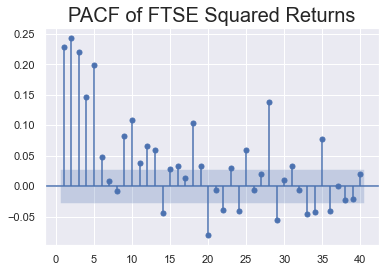

In [15]:
# squared term of ACF is to understand the volability, the first 6 lags are significant, means that there're short-term relationship between variance
# and this is called variance clustering, high variation comes with high variation
sgt.plot_pacf(df.squared_returns[1:], zero=False, alpha=0.05, lags=40, method=('ols'))
plt.title('PACF of FTSE Squared Returns', size=20)
plt.show()

## The arch_model() Method

In [16]:
from arch import arch_model

In [17]:
model_1 = arch_model(df.returns[1:]) # if you don't specify anything, if will give out three models
result_1 = model_1.fit() # can add update_freq=5 to prevent from a lot of verbose (information)
result_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10655466386.949347
Iteration:      2,   Func. Count:     15,   Neg. LLF: 952793978.0630096
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.028860263045
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.036751000337
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712762828675
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418132248602
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.288792382339
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879345056244
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.08804424179
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.05847839524
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.058367475622
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189893
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189178
Optimization terminated successfully    (Exit mode 0)
           

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Mar 10 2021   Df Residuals:                     5019
Time:                        22:21:29   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

In [19]:
# look at the r-squared, it's zero, meaning that the residual is just like a constant, there would be no variance
# R-squared is a useful measure, but NOT for ARCH model
# the log likelihood is -7660 better than ARIMA and ARMA, even the simpliest ARCH model would outperform those
# ARCH can only be used to predict future variance rather than future returns
model_1 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=1)
result_1 = model_1.fit(update_freq=5)
result_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Wed, Mar 10 2021   Df Residuals:                     5019
Time:                        22:43:42   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

## The Simple ARCH(1) 

In [20]:
# mean = 'Constant', 'Zero', 'AR'. and if AR, you need to specify lags = [2,3,6]
# dist = 't', 'ged'
# ARCH(1) means that p=1
model_1 = arch_model(df.returns[1:], mean='Zero', vol='ARCH', p=1)
result_1 = model_1.fit(update_freq=5)
result_1.summary()

Iteration:      5,   Func. Count:     20,   Neg. LLF: 7662.9347317604725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7662.934731760461
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7662.93
Distribution:                  Normal   AIC:                           15329.9
Method:            Maximum Likelihood   BIC:                           15342.9
                                        No. Observations:                 5020
Date:                Wed, Mar 10 2021   Df Residuals:                     5020
Time:                        22:49:54   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9244  4.332e-02     21.340 4.807e-101 [  0.839,  1.009]
alpha[1]       0.3640  4.945e-02      7.361  1.825e-13 [  0.267,  0.461]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag ARCH Models

In [21]:
# ARCH(2) - one more variable with the squared term of residual two periods ago
model_2 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=2)
result_2 = model_2.fit(update_freq=5)
result_2.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.02930517937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Wed, Mar 10 2021   Df Residuals:                     5019
Time:                        22:52:40   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [22]:
model_3 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=3)
result_3 = model_3.fit(update_freq=5)
result_3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7496.4079308108885
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7277.050452148393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Wed, Mar 10 2021   Df Residuals:                     5019
Time:                        22:55:47   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""